<a href="https://colab.research.google.com/github/fajarafriad1/Data-Analysis-and-Machine-Learning/blob/main/Sales%20Analysis%20and%20Forecast/Sales_Analysis_and_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/bootcamp xsis/Sales Analysis and Forecast
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/bootcamp xsis/Sales Analysis and Forecast


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 50)

In [3]:
import holidays

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler  # Import StandardScaler class for feature standardization
from sklearn.linear_model import LinearRegression  # Import LinearRegression class for linear regression
from sklearn.linear_model import LogisticRegression  # Import LinearRegression class for linear regression
from sklearn.tree import DecisionTreeRegressor  # Import DecisionTreeRegressor class for decision tree regression
from sklearn.ensemble import RandomForestRegressor  # Import RandomForestRegressor class for random forest regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error, make_scorer, mean_absolute_error, mean_squared_error # Import functions for evaluation metrics

In [4]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


In [5]:
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d')

### Data Understanding

In [6]:
df_train.shape

(136950, 6)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        136950 non-null  int64         
 1   date      136950 non-null  datetime64[ns]
 2   country   136950 non-null  object        
 3   store     136950 non-null  object        
 4   product   136950 non-null  object        
 5   num_sold  136950 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 6.3+ MB


In [8]:
df_train.describe(include=object)

,country,store,product
count,136950,136950,136950
unique,5,3,5
top,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
freq,27390,45650,27390


In [9]:
df_train.describe(include=['int64', 'float64'])

,id,num_sold
count,136950.00000,136950.000000
mean,68474.50000,165.522636
std,39534.20402,183.691575
min,0.00000,2.000000
25%,34237.25000,46.000000
50%,68474.50000,98.000000
75%,102711.75000,184.000000
max,136949.00000,1380.000000


In [10]:
df_train[df_train.isna().any(axis=1)]

,id,date,country,store,product,num_sold


In [11]:
df_train[df_train.duplicated()]

,id,date,country,store,product,num_sold


In [12]:
df_train.columns

Index(['id', 'date', 'country', 'store', 'product', 'num_sold'], dtype='object')

In [13]:
for i, col in zip(range(3), df_train.select_dtypes(include=object).columns):
  print(i, col)

0 country
1 store
2 product


### Exploratory Data Analysis

#### Distribution (num_sold)

<Axes: title={'center': 'Distribution of Sales (num_sold)'}, xlabel='num_sold', ylabel='Count'>

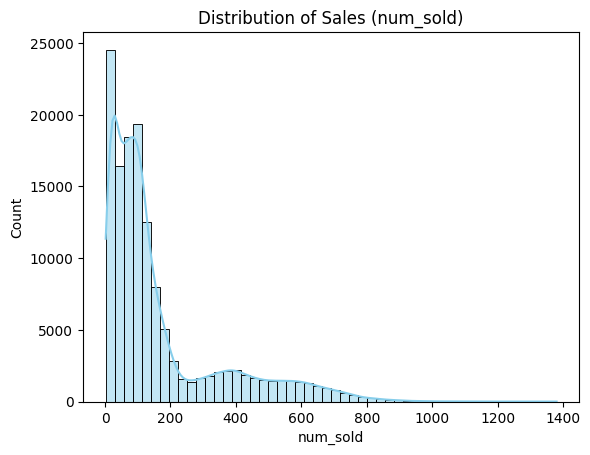

In [14]:
distribution = sns.histplot(df_train['num_sold'], bins=50, kde=True, color='skyblue')
distribution.set_title('Distribution of Sales (num_sold)')
distribution

#### Box Plot

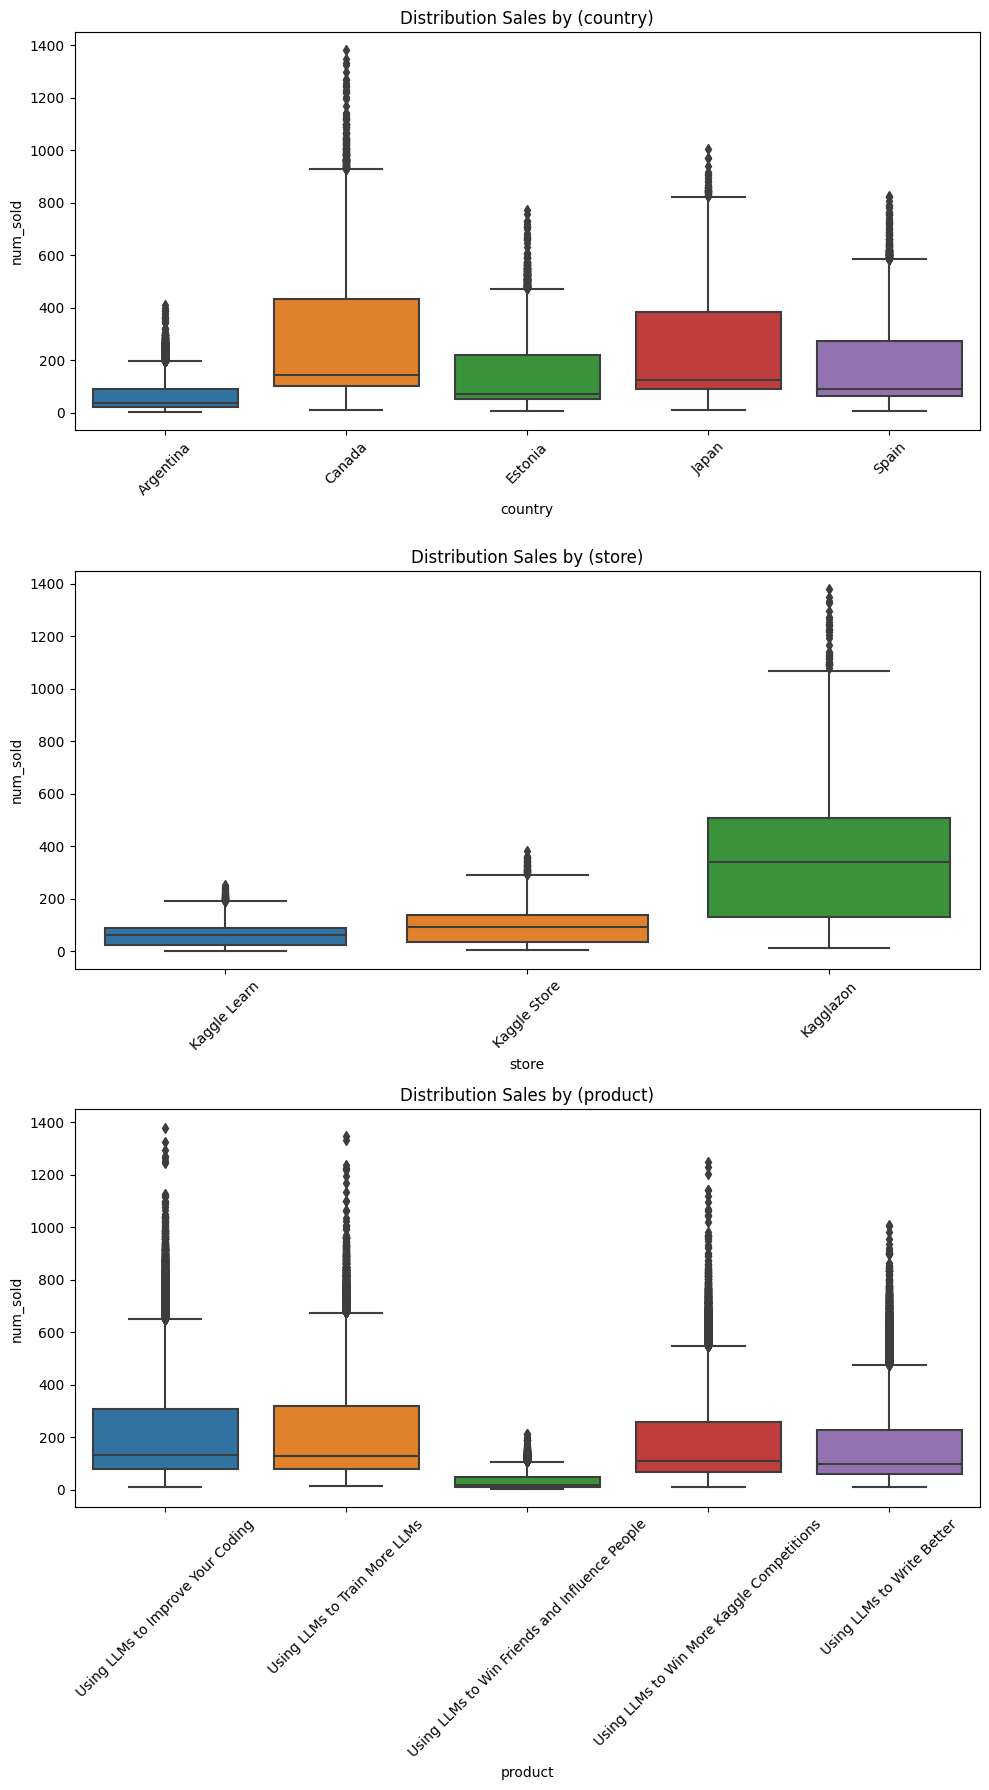

In [15]:
nrows = len(df_train.select_dtypes(include=object).columns)
fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(10,18))
ax = ax.flatten()
for i, col in zip(range(nrows), df_train.select_dtypes(include=object).columns):
  sns.boxplot(data = df_train, x=col, y='num_sold', ax=ax[i])
  ax[i].set_title(f'Distribution Sales by ({col})')
  ax[i].tick_params(axis='x', rotation = 45)
  plt.tight_layout()

#### Line PLot

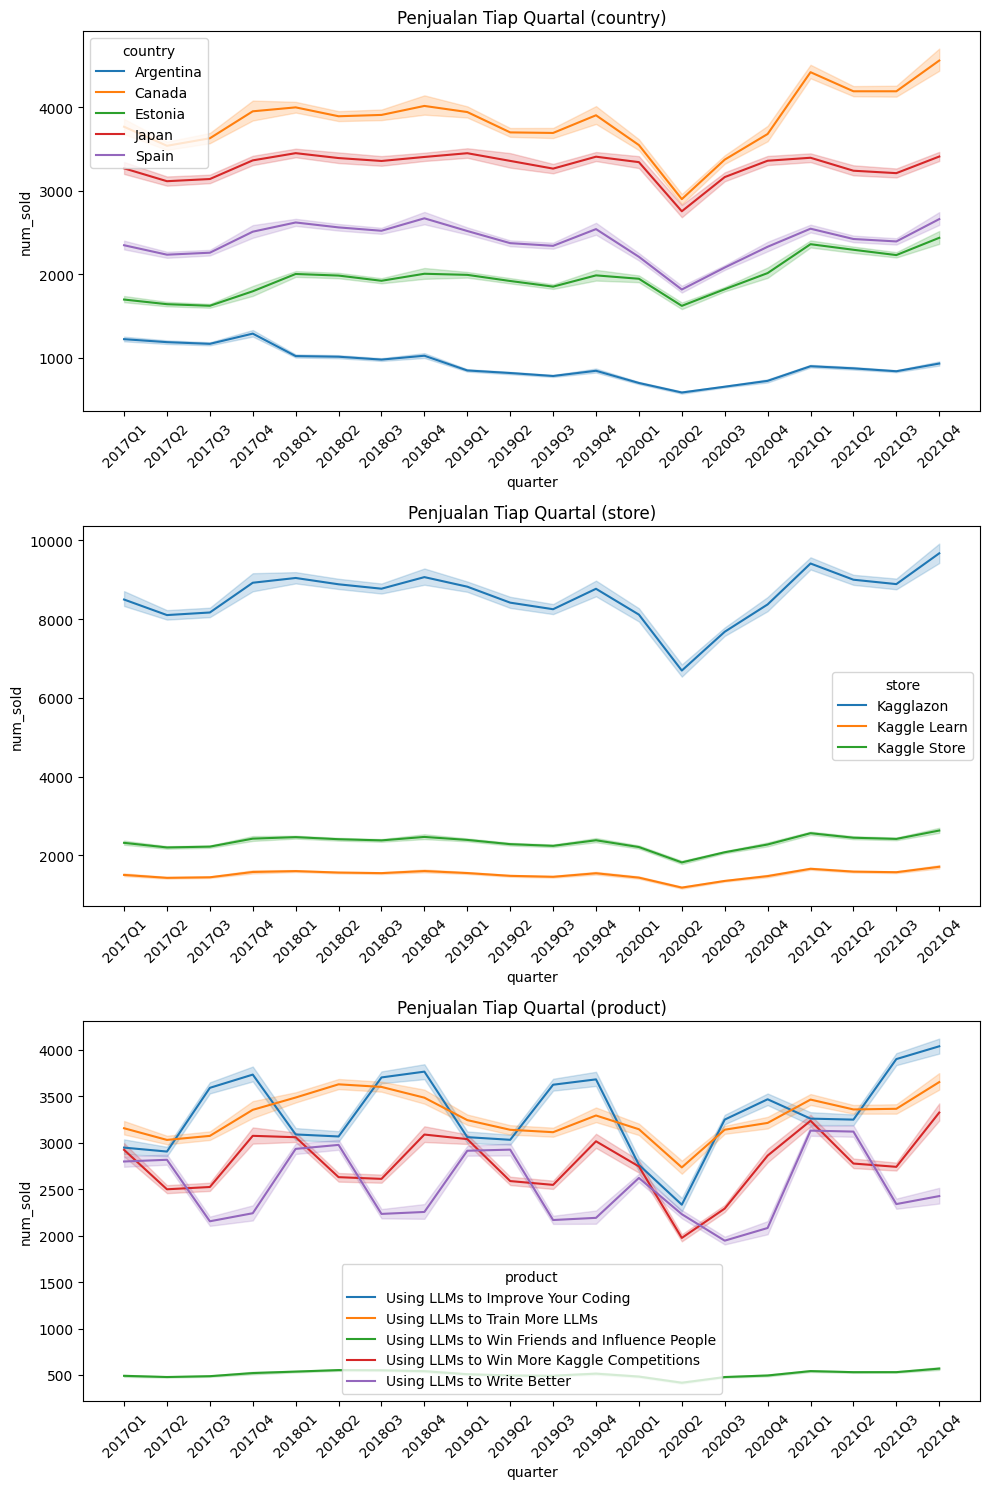

In [16]:
nrows = len(df_train.select_dtypes(include=object).columns)
fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(10,15))
ax = ax.flatten()
for i, col in zip(range(nrows), df_train.select_dtypes(include=object).columns):
  df_line = df_train.groupby(['date', col], as_index=False)['num_sold'].sum()
  df_line['quarter'] = pd.PeriodIndex(df_line['date'], freq='Q')
  df_line['quarter'] = df_line['quarter'].astype(str)
  lp = sns.lineplot(data=df_line, x='quarter', y='num_sold', hue=col, ax=ax[i])
  ax[i].set_title(f'Penjualan Tiap Quartal ({col})')
  ax[i].tick_params(axis='x', rotation = 45)
  plt.tight_layout()

#### Feature Engineering

In [17]:
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day_of_week'] = df_train['date'].dt.dayofweek  # Monday=0, Sunday=6
df_train['day_number'] = df_train['date'].dt.day
df_train['weekend'] = np.where((df_train['day_of_week'] == 5) | (df_train['day_of_week'] == 6), 1, 0)
df_train

,id,date,country,store,product,num_sold,year,month,day_of_week,day_number,weekend
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63,2017,1,6,1,1
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66,2017,1,6,1,1
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9,2017,1,6,1,1
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59,2017,1,6,1,1
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49,2017,1,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...
136945,136945,2021-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,700,2021,12,4,31,0
136946,136946,2021-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,752,2021,12,4,31,0
136947,136947,2021-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,111,2021,12,4,31,0
136948,136948,2021-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,641,2021,12,4,31,0


In [18]:
years_list = df_train['year'].unique()
AR_holidays = holidays.CountryHoliday('AR', years=years_list)
CA_holidays = holidays.CountryHoliday('CA', years=years_list)
EE_holidays = holidays.CountryHoliday('EE', years=years_list)
JP_holidays = holidays.CountryHoliday('JP', years=years_list)
ES_holidays = holidays.CountryHoliday('ES', years=years_list)

df_train['AR_holiday'] = df_train.loc[df_train['country'] == 'Argentina', 'date'].apply(lambda d: d in AR_holidays)
df_train['CA_holiday'] = df_train.loc[df_train['country'] == 'Canada', 'date'].apply(lambda d: d in CA_holidays)
df_train['EE_holiday'] = df_train.loc[df_train['country'] == 'Estonia', 'date'].apply(lambda d: d in EE_holidays)
df_train['JP_holiday'] = df_train.loc[df_train['country'] == 'Japan', 'date'].apply(lambda d: d in JP_holidays)
df_train['ES_holiday'] = df_train.loc[df_train['country'] == 'Spain', 'date'].apply(lambda d: d in ES_holidays)

country_holiday = ['AR_holiday', 'CA_holiday', 'EE_holiday', 'JP_holiday', 'ES_holiday']
df_train = df_train.fillna('')
df_train['holiday'] = df_train['AR_holiday'].astype('str') + df_train['CA_holiday'].astype('str') + df_train['EE_holiday'].astype('str') + df_train['JP_holiday'].astype('str') + df_train['ES_holiday'].astype('str')
df_train['holiday'] = np.where(df_train['holiday'] == 'True', 1, 0)
df_train = df_train.drop(country_holiday, axis=1)

### Data Preprocessing

In [19]:
train_encoded = pd.get_dummies(df_train, columns=['country', 'store', 'product'], drop_first=True)

In [20]:
train_encoded

,id,date,num_sold,year,month,day_of_week,day_number,weekend,holiday,country_Canada,country_Estonia,country_Japan,country_Spain,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better
0,0,2017-01-01,63,2017,1,6,1,1,1,0,0,0,0,1,0,0,0,0,0
1,1,2017-01-01,66,2017,1,6,1,1,1,0,0,0,0,1,0,1,0,0,0
2,2,2017-01-01,9,2017,1,6,1,1,1,0,0,0,0,1,0,0,1,0,0
3,3,2017-01-01,59,2017,1,6,1,1,1,0,0,0,0,1,0,0,0,1,0
4,4,2017-01-01,49,2017,1,6,1,1,1,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136945,136945,2021-12-31,700,2021,12,4,31,0,0,0,0,0,1,0,0,0,0,0,0
136946,136946,2021-12-31,752,2021,12,4,31,0,0,0,0,0,1,0,0,1,0,0,0
136947,136947,2021-12-31,111,2021,12,4,31,0,0,0,0,0,1,0,0,0,1,0,0
136948,136948,2021-12-31,641,2021,12,4,31,0,0,0,0,0,1,0,0,0,0,1,0


In [21]:
X = train_encoded.drop(columns=['id', 'num_sold', 'date'])
y = train_encoded['num_sold']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
print(f'X_test shape : {X_train.shape}')
print(f'X_val shape : {X_val.shape}')

X_test shape : (109560, 16)
X_val shape : (27390, 16)


### Modelling

In [23]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [24]:
testing_size = int(len(df_train) * 0.3)
def evaluate_tscv(model):

    tscv = TimeSeriesSplit(n_splits=3, test_size=testing_size)
    for i, (train_index, test_index) in enumerate(tscv.split(X)):

        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_val, y_val = X.iloc[test_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        pred = model.predict(X_val)

        smape_score = smape(y_val, pred)
        mae_score = mean_absolute_error(y_val, pred)
        mse_score = mean_squared_error(y_val, pred)
        model_name = str(model.__class__.__name__)

    df_eval = {'model_name':model_name, 'smape_score':np.mean(smape_score), 'mae_score':np.mean(mae_score)}
    return df_eval

In [25]:
def evaluate(model):

    model_name = []
    smape_scores = []
    mae_scores = []
    preds = []


    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    smape_score = smape(y_val, pred)
    mae_score = mean_absolute_error(y_val, pred)
    model_name = str(model.__class__.__name__)

    df_eval = {'model_name':model_name, 'smape_score':np.mean(smape_score), 'mae_score':np.mean(mae_score)}
    return df_eval

In [26]:
lin_reg = LinearRegression()
dt_reg = DecisionTreeRegressor(random_state=42)
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
gr_reg = GradientBoostingRegressor(random_state=42)
ab_reg = AdaBoostRegressor(random_state=42)
xgb_reg = XGBRegressor(random_state=42)
lgb_reg = LGBMRegressor(random_state=42)

In [27]:
models = [lin_reg, dt_reg, rf_reg, gr_reg, ab_reg, xgb_reg, lgb_reg]

In [28]:
scores_tscv = pd.DataFrame([evaluate_tscv(model) for model in models])
scores_tscv

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 71
[LightGBM] [Info] Number of data points in the train set: 13695, number of used features: 15
[LightGBM] [Info] Start training from score 160.242132
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 54780, number of used features: 16
[LightGBM] [Info] Start training from score 167.599197
[LightGBM] [Warning] F

,model_name,smape_score,mae_score
0,LinearRegression,64.337005,67.929365
1,DecisionTreeRegressor,17.617150,26.008446
2,RandomForestRegressor,17.223861,25.322631
3,GradientBoostingRegressor,51.766797,44.194768
4,AdaBoostRegressor,68.228710,90.164280
5,XGBRegressor,23.841742,28.855210
6,LGBMRegressor,24.766425,30.045523


In [29]:
scores = pd.DataFrame([evaluate(model) for model in models])
scores

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82
[LightGBM] [Info] Number of data points in the train set: 109560, number of used features: 16
[LightGBM] [Info] Start training from score 165.561072


,model_name,smape_score,mae_score
0,LinearRegression,60.454651,65.584424
1,DecisionTreeRegressor,6.883562,11.188974
2,RandomForestRegressor,5.366135,8.598026
3,GradientBoostingRegressor,35.839780,31.950269
4,AdaBoostRegressor,74.558141,100.244098
5,XGBRegressor,10.330971,9.782504
6,LGBMRegressor,11.775797,10.037308


### Hyperparameter Tuning

#### Function Hyperparameter Tuning

In [30]:
tscv = TimeSeriesSplit(n_splits=2, test_size=testing_size)

def evaluate_tuning(model):

    model.fit(X_train, y_train)
    pred = model.best_estimator_.predict(X_val)
    smape_score = smape(y_val, pred)
    mae_score = mean_absolute_error(y_val, pred)
    model_name = str(model.estimator.__class__.__name__)
    print(model.best_params_)

    df_eval = {'model_name':model_name, 'smape_score':np.mean(smape_score), 'mae_score':np.mean(mae_score), 'best_param':model.best_params_}
    return df_eval

#### Inisiasi Parameter
pilih 3 model terbail (SecisionTree, RandomForest, dan XGB)

In [31]:
dt_reg_hyperpara = {'max_depth':[15, 25, 50, None], 'min_samples_leaf': [2, 3, 4, 5, 8]}

rf_reg_hyperpara = {'max_depth': [8, 10],
                    'min_samples_leaf': [3, 4],
                    'min_samples_split': [5, 10],
                    'max_features': [8, 16, 24],
                    'n_estimators': [100]}

xgb_reg_hyperpara = {'max_depth': [8, 10, 20],
                     'min_child_weight': [8, 10],
                     'learning_rate': [.3, .2, .1],
                     'n_estimators': [100],
                     'colsample_bytree': [.9, .8, .7]}

rf_gscv = GridSearchCV(rf_reg, rf_reg_hyperpara, cv=tscv, n_jobs=-1, verbose=10)
dt_gscv = GridSearchCV(dt_reg, dt_reg_hyperpara, cv=tscv, n_jobs=-1, verbose=10)
xgb_gscv = GridSearchCV(xgb_reg, xgb_reg_hyperpara, cv=tscv, n_jobs=-1, verbose=10)

#### Evaluasi Model
- model terbaik adalah XGBoost

In [32]:
hp_models = [dt_gscv, rf_gscv, xgb_gscv]
scores = pd.DataFrame([evaluate_tuning(model) for model in hp_models])
scores

Fitting 2 folds for each of 20 candidates, totalling 40 fits
{'max_depth': 25, 'min_samples_leaf': 5}
Fitting 2 folds for each of 24 candidates, totalling 48 fits
{'max_depth': 10, 'max_features': 16, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}
Fitting 2 folds for each of 54 candidates, totalling 108 fits
{'colsample_bytree': 0.9, 'learning_rate': 0.3, 'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 100}


,model_name,smape_score,mae_score,best_param
0,DecisionTreeRegressor,6.015503,9.693798,"{'max_depth': 25, 'min_samples_leaf': 5}"
1,RandomForestRegressor,8.926684,14.342038,"{'max_depth': 10, 'max_features': 16, 'min_sam..."
2,XGBRegressor,6.687685,8.191051,"{'colsample_bytree': 0.9, 'learning_rate': 0.3..."


In [45]:
hp_model_name = [str(model.estimator.__class__.__name__) for model in hp_models]

dt_reg_best_param = scores['best_param'].loc[scores['model_name']==hp_model_name[0]].iloc[0]
rf_reg_best_param = scores['best_param'].loc[scores['model_name']==hp_model_name[1]].iloc[0]
xgb_reg_best_param = scores['best_param'].loc[scores['model_name']==hp_model_name[2]].iloc[0]

#### Check the results

In [52]:
validation = X_val.copy()
# y_val (y_true)
validation['y_val'] = y_val

# prediction (not tuned)
dt_reg.fit(X_train, y_train)
dt_y_val_pred = dt_reg.predict(X_val)
validation['dt_reg_y_val_pred'] = dt_y_val_pred

rf_reg.fit(X_train, y_train)
rf_y_val_pred = rf_reg.predict(X_val)
validation['rf_reg_y_val_pred'] = rf_y_val_pred

xgb_reg.fit(X_train, y_train)
xgb_y_val_pred = xgb_reg.predict(X_val)
validation['xgb_reg_y_val_pred'] = xgb_y_val_pred

# prediction (hyperparmeter best param tuned)
dt_reg_best = DecisionTreeRegressor(**dt_reg_best_param)
rf_reg_best = RandomForestRegressor(**rf_reg_best_param)
xgb_reg_best = XGBRegressor(**xgb_reg_best_param)

dt_reg_best.fit(X_train, y_train)
dt_reg_y_val_pred_best = dt_reg_best.predict(X_val)
validation['dt_reg_y_val_pred_best'] = dt_reg_y_val_pred_best

rf_reg_best.fit(X_train, y_train)
rf_reg_y_val_pred_best = rf_reg_best.predict(X_val)
validation['rf_reg_y_val_pred_best'] = rf_reg_y_val_pred_best

xgb_reg_best.fit(X_train, y_train)
xgb_reg_y_val_pred_best = xgb_reg_best.predict(X_val)
validation['xgb_reg_y_val_pred_best'] = xgb_reg_y_val_pred_best

validation.head()

,year,month,day_of_week,day_number,weekend,holiday,country_Canada,country_Estonia,country_Japan,country_Spain,...,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better,y_val,dt_reg_y_val_pred,rf_reg_y_val_pred,xgb_reg_y_val_pred,dt_reg_y_val_pred_best,rf_reg_y_val_pred_best,xgb_reg_y_val_pred_best
135486,2021,12,6,12,1,0,0,1,0,0,...,0,0,0,129,142.0,136.07,141.114487,127.750000,123.159732,130.479843
112235,2021,2,4,5,0,0,0,1,0,0,...,0,0,0,110,104.0,107.24,107.188690,107.333333,112.581847,108.666527
73585,2019,9,0,9,0,0,0,0,0,0,...,0,0,0,154,163.0,164.99,209.214203,160.857143,134.495318,181.527557
132039,2021,10,2,27,0,0,0,1,0,0,...,0,0,1,63,61.0,63.83,67.678032,64.500000,77.276823,62.910210
7090,2017,4,2,5,0,0,0,1,0,0,...,0,0,0,249,263.0,254.95,260.766327,254.714286,344.252823,255.065948


### Apply model on test.csv / Submission

In [69]:
def preprocess(df):
  df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
  df['year'] = df['date'].dt.year
  df['month'] = df['date'].dt.month
  df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
  df['day_number'] = df['date'].dt.day
  df['weekend'] = np.where((df['day_of_week'] == 5) | (df['day_of_week'] == 6), 1, 0)

  years_list = df['year'].unique()
  AR_holidays = holidays.CountryHoliday('AR', years=years_list)
  CA_holidays = holidays.CountryHoliday('CA', years=years_list)
  EE_holidays = holidays.CountryHoliday('EE', years=years_list)
  JP_holidays = holidays.CountryHoliday('JP', years=years_list)
  ES_holidays = holidays.CountryHoliday('ES', years=years_list)

  df['AR_holiday'] = df.loc[df['country'] == 'Argentina', 'date'].apply(lambda d: d in AR_holidays)
  df['CA_holiday'] = df.loc[df['country'] == 'Canada', 'date'].apply(lambda d: d in CA_holidays)
  df['EE_holiday'] = df.loc[df['country'] == 'Estonia', 'date'].apply(lambda d: d in EE_holidays)
  df['JP_holiday'] = df.loc[df['country'] == 'Japan', 'date'].apply(lambda d: d in JP_holidays)
  df['ES_holiday'] = df.loc[df['country'] == 'Spain', 'date'].apply(lambda d: d in ES_holidays)

  country_holiday = ['AR_holiday', 'CA_holiday', 'EE_holiday', 'JP_holiday', 'ES_holiday']
  df = df.fillna('')
  df['holiday'] = df['AR_holiday'].astype('str') + df['CA_holiday'].astype('str') + df['EE_holiday'].astype('str') + df['JP_holiday'].astype('str') + df['ES_holiday'].astype('str')
  df['holiday'] = np.where(df['holiday'] == 'True', 1, 0)
  df = df.drop(country_holiday, axis=1)

  df = pd.get_dummies(df, columns=['country', 'store', 'product'], drop_first=True)
  return df

In [70]:
df_test = pd.read_csv('test.csv')
df_test.head()

,id,date,country,store,product
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better


In [71]:
df_test = preprocess(df_test)
df_test.head()

,id,date,year,month,day_of_week,day_number,weekend,holiday,country_Canada,country_Estonia,country_Japan,country_Spain,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better
0,136950,2022-01-01,2022,1,5,1,1,1,0,0,0,0,1,0,0,0,0,0
1,136951,2022-01-01,2022,1,5,1,1,1,0,0,0,0,1,0,1,0,0,0
2,136952,2022-01-01,2022,1,5,1,1,1,0,0,0,0,1,0,0,1,0,0
3,136953,2022-01-01,2022,1,5,1,1,1,0,0,0,0,1,0,0,0,1,0
4,136954,2022-01-01,2022,1,5,1,1,1,0,0,0,0,1,0,0,0,0,1


In [74]:
X_test = df_test.drop(columns=['id', 'date'])
y_test_pred = xgb_reg_best.predict(X_test)

submission = X_test.copy()
submission['num_sold'] = np.floor(y_test_pred)
submission['num_sold'] = submission['num_sold'].astype(int)

In [77]:
submission

,year,month,day_of_week,day_number,weekend,holiday,country_Canada,country_Estonia,country_Japan,country_Spain,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better,num_sold
0,2022,1,5,1,1,1,0,0,0,0,1,0,0,0,0,0,39
1,2022,1,5,1,1,1,0,0,0,0,1,0,1,0,0,0,32
2,2022,1,5,1,1,1,0,0,0,0,1,0,0,1,0,0,1
3,2022,1,5,1,1,1,0,0,0,0,1,0,0,0,1,0,34
4,2022,1,5,1,1,1,0,0,0,0,1,0,0,0,0,1,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27370,2022,12,5,31,1,0,0,0,0,1,0,0,0,0,0,0,719
27371,2022,12,5,31,1,0,0,0,0,1,0,0,1,0,0,0,719
27372,2022,12,5,31,1,0,0,0,0,1,0,0,0,1,0,0,122
27373,2022,12,5,31,1,0,0,0,0,1,0,0,0,0,1,0,648
